In [ ]:
from pypots.data import load_specific_dataset
import tsdb
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar, mnar_t
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.imputation import CSDI
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_rmse
from pypots.utils.metrics import calc_mre
from pypots.utils.metrics import calc_quantile_crps
from scipy import stats

data_air_quality = tsdb.load("beijing_multisite_air_quality")
data_air_quality = data_air_quality['X']

data_air_2014 = data_air_quality[data_air_quality['year'] == 2014].groupby(by=['year', 'month', 'day', 'hour'])['PM2.5'].apply(list).reset_index(name='new')
X = [np.array(row[0]) for row in pd.DataFrame(data_air_2014['new']).values]
X = np.vstack(X)
X_ori = X.reshape(365, 24, -1)
X = np.copy(X_ori)
X_ori = X_ori[:36, :, :]
X = X[36:, :, :]
X_ori_missed = mcar(X_ori, 0.1)
dataset = {"X" : X}

2024-05-06 13:21:15 [INFO]: You're using dataset beijing_multisite_air_quality, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/beijing_multisite_air_quality
2024-05-06 13:21:15 [INFO]: Dataset beijing_multisite_air_quality has already been downloaded. Processing directly...
2024-05-06 13:21:15 [INFO]: Dataset beijing_multisite_air_quality has already been cached. Loading from cache directly...
2024-05-06 13:21:15 [INFO]: Loaded successfully!


In [ ]:
def calc_nlpd(y_pred, y_true, mask, y_pred_std):
    metric = (((y_true - y_pred)**2) * mask) / ((2 * y_pred_std**2) + 1e-12) + (np.log(y_pred_std + 1e-12) * mask) + 0.5 * np.log(2 * np.pi)

    return metric.sum() / (mask.sum() + 1e-12)

def calc_picp(y_pred, y_true, mask, y_pred_std, alpha=0.90):
    p_left, p_right = stats.norm.interval(confidence=alpha, loc=y_pred, scale=y_pred_std)
    metric = (y_true > p_left) * (y_true <= p_right)

    return (metric * mask).sum() / (mask.sum() + 1e-12)


n_steps=X.shape[1]
n_features=X.shape[2]
print(X.shape)

(365, 24, 12)


In [ ]:
data_air_quality

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,20.0,48.0,2.0,NaN,500.0,NaN,12.5,1013.5,-16.2,0.0,NW,2.4,Tiantan
35060,35061,2017,2,28,20,11.0,34.0,3.0,36.0,500.0,NaN,11.6,1013.6,-15.1,0.0,WNW,0.9,Tiantan
35061,35062,2017,2,28,21,18.0,32.0,4.0,48.0,500.0,48.0,10.8,1014.2,-13.3,0.0,NW,1.1,Tiantan
35062,35063,2017,2,28,22,15.0,42.0,5.0,52.0,600.0,44.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Tiantan


In [ ]:
csdi = CSDI(n_features=n_features, n_layers=4, n_heads=8, n_channels=64, d_time_embedding=128, d_feature_embedding=128, d_diffusion_embedding=128, epochs=150, saving_path='csdi_model')

csdi.fit(dataset)

2024-05-06 13:21:17 [INFO]: No given device, using default device: cuda
2024-05-06 13:21:17 [INFO]: Model files will be saved to csdi_model/20240506_T132117
2024-05-06 13:21:17 [INFO]: Tensorboard file will be saved to csdi_model/20240506_T132117/tensorboard
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-05-06 13:21:17 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 472,385
2024-05-06 13:21:28 [INFO]: Epoch 001 - training loss: 0.9887
2024-05-06 13:21:30 [INFO]: Epoch 002 - training loss: 0.9437
2024-05-06 13:21:34 [INFO]: Epoch 003 - training loss: 0.9232
2024-05-06 13:21:37 [INF

In [ ]:
csdi.optimizer.torch_optimizer.param_groups[0]['lr'] = 0.0001
csdi.epochs = 30
csdi.fit(dataset)

2024-05-06 13:28:21 [INFO]: Epoch 001 - training loss: 0.7903
2024-05-06 13:28:23 [INFO]: Epoch 002 - training loss: 0.7466
2024-05-06 13:28:26 [INFO]: Epoch 003 - training loss: 0.7691
2024-05-06 13:28:28 [INFO]: Epoch 004 - training loss: 0.7709
2024-05-06 13:28:31 [INFO]: Epoch 005 - training loss: 0.7784
2024-05-06 13:28:33 [INFO]: Epoch 006 - training loss: 0.7772
2024-05-06 13:28:36 [INFO]: Epoch 007 - training loss: 0.7575
2024-05-06 13:28:38 [INFO]: Epoch 008 - training loss: 0.7631
2024-05-06 13:28:41 [INFO]: Epoch 009 - training loss: 0.7196
2024-05-06 13:28:43 [INFO]: Epoch 010 - training loss: 0.7807
2024-05-06 13:28:46 [INFO]: Epoch 011 - training loss: 0.7304
2024-05-06 13:28:48 [INFO]: Epoch 012 - training loss: 0.8127
2024-05-06 13:28:51 [INFO]: Epoch 013 - training loss: 0.7570
2024-05-06 13:28:53 [INFO]: Epoch 014 - training loss: 0.7902
2024-05-06 13:28:56 [INFO]: Epoch 015 - training loss: 0.7530
2024-05-06 13:28:58 [INFO]: Epoch 016 - training loss: 0.7438
2024-05-

In [ ]:
csdi.optimizer.torch_optimizer.param_groups[0]['lr'] = 0.00001
csdi.epochs = 20
csdi.fit(dataset)

2024-05-06 13:29:36 [INFO]: Epoch 001 - training loss: 0.7900
2024-05-06 13:29:39 [INFO]: Epoch 002 - training loss: 0.7569
2024-05-06 13:29:41 [INFO]: Epoch 003 - training loss: 0.7813
2024-05-06 13:29:44 [INFO]: Epoch 004 - training loss: 0.7744
2024-05-06 13:29:46 [INFO]: Epoch 005 - training loss: 0.7655
2024-05-06 13:29:49 [INFO]: Epoch 006 - training loss: 0.7668
2024-05-06 13:29:51 [INFO]: Epoch 007 - training loss: 0.7647
2024-05-06 13:29:53 [INFO]: Epoch 008 - training loss: 0.8109
2024-05-06 13:29:55 [INFO]: Epoch 009 - training loss: 0.7386
2024-05-06 13:29:57 [INFO]: Epoch 010 - training loss: 0.7410
2024-05-06 13:29:59 [INFO]: Epoch 011 - training loss: 0.7439
2024-05-06 13:30:01 [INFO]: Epoch 012 - training loss: 0.7588
2024-05-06 13:30:04 [INFO]: Epoch 013 - training loss: 0.7741
2024-05-06 13:30:06 [INFO]: Epoch 014 - training loss: 0.8050
2024-05-06 13:30:08 [INFO]: Epoch 015 - training loss: 0.7750
2024-05-06 13:30:10 [INFO]: Epoch 016 - training loss: 0.7703
2024-05-

In [ ]:
n_preds = 30
imputation_csdi = csdi.predict(dataset, n_sampling_times=n_preds)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X_ori_missed) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation

In [ ]:
mae_csdi = calc_mae(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
rmse_csdi = calc_rmse(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
mape_csdi = calc_mre(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
crps_csdi = calc_quantile_crps(imputation_csdi['imputation'], np.nan_to_num(X_ori), indicating_mask)
nlpd_csdi = calc_nlpd(np.mean(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_csdi['imputation'], axis=1))
picp_csdi = calc_picp(np.mean(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_csdi['imputation'], axis=1))

/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
print(mae_csdi, rmse_csdi, mape_csdi, crps_csdi, nlpd_csdi, picp_csdi)

17.2103546492641 32.90719556375586 0.20238694188226783 0.3697513279161955 12.829511082643142 0.9141488217463575


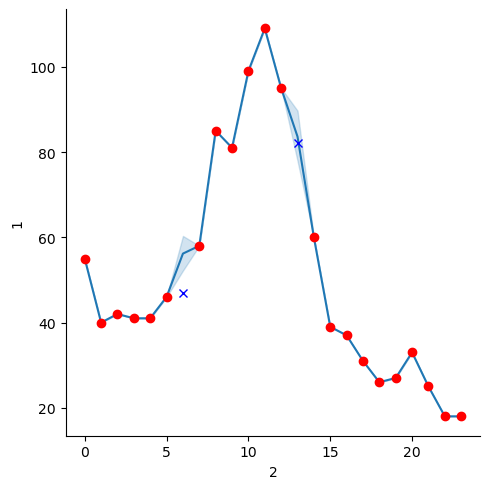

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

day = 132
station = 10

d = pd.DataFrame(columns=['1', '2'])
for i in range(n_preds):
    for j in range(n_steps):
        d = pd.concat([d, pd.DataFrame([{'1': imputation_csdi['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
sns.relplot(data=d, y = '1', x='2', kind='line')
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')


In [ ]:
saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256, d_inner=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=200, saving_path='saits')
saits.fit(dataset)

2024-05-06 13:40:25 [INFO]: No given device, using default device: cuda
2024-05-06 13:40:25 [INFO]: Model files will be saved to saits/20240506_T134025
2024-05-06 13:40:25 [INFO]: Tensorboard file will be saved to saits/20240506_T134025/tensorboard
2024-05-06 13:40:25 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,335,920
2024-05-06 13:40:33 [INFO]: Epoch 001 - training loss: 168.6630
2024-05-06 13:40:36 [INFO]: Epoch 002 - training loss: 163.9131
2024-05-06 13:40:39 [INFO]: Epoch 003 - training loss: 157.3715
2024-05-06 13:40:42 [INFO]: Epoch 004 - training loss: 150.0103
2024-05-06 13:40:45 [INFO]: Epoch 005 - training loss: 144.3637
2024-05-06 13:40:48 [INFO]: Epoch 006 - training loss: 140.9942
2024-05-06 13:40:51 [INFO]: Epoch 007 - training loss: 132.4168
2024-05-06 13:40:54 [INFO]: Epoch 008 - training loss: 128.2838
2024-05-06 13:40:57 [INFO]: Epoch 009 - training loss: 126.4449
2024-05-06 13:41:00 [INFO]: Epoch 010 - training lo

In [ ]:
imputation_saits = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values
mae_saits = calc_mae(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
rmse_saits = calc_rmse(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
mape_saits = calc_mre(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
crps_saits = calc_quantile_crps(np.expand_dims(imputation_saits['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)

In [ ]:
print(mae_saits, rmse_saits, mape_saits, crps_saits)

19.263989061722132 31.314703990395056 0.2265368677235311 0.22653685118022718


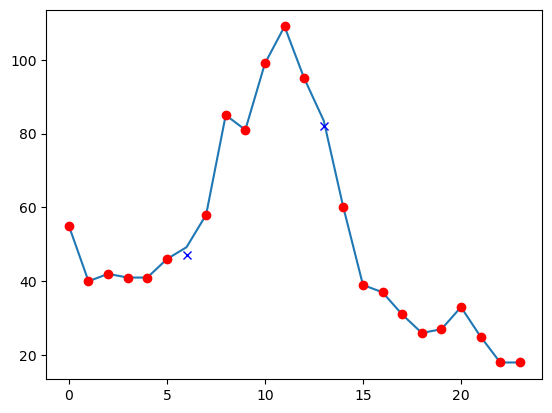

In [ ]:
plt.plot(imputation_saits['imputation'][day][:, station])
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
from pypots.imputation import BRITS

brits = BRITS(n_steps=n_steps, n_features=n_features, rnn_hidden_size=128, epochs=200, saving_path='brits')
brits.fit(dataset)

2024-05-06 13:49:43 [INFO]: No given device, using default device: cuda
2024-05-06 13:49:43 [INFO]: Model files will be saved to brits/20240506_T134943
2024-05-06 13:49:43 [INFO]: Tensorboard file will be saved to brits/20240506_T134943/tensorboard
2024-05-06 13:49:43 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 165,344
2024-05-06 13:50:07 [INFO]: Epoch 001 - training loss: 158.0784
2024-05-06 13:50:31 [INFO]: Epoch 002 - training loss: 153.2938
2024-05-06 13:50:54 [INFO]: Epoch 003 - training loss: 140.6340
2024-05-06 13:51:17 [INFO]: Epoch 004 - training loss: 127.6687
2024-05-06 13:51:39 [INFO]: Epoch 005 - training loss: 119.5229
2024-05-06 13:52:01 [INFO]: Epoch 006 - training loss: 112.2505
2024-05-06 13:52:24 [INFO]: Epoch 007 - training loss: 107.3252
2024-05-06 13:52:47 [INFO]: Epoch 008 - training loss: 98.5766
2024-05-06 13:53:10 [INFO]: Epoch 009 - training loss: 94.3633
2024-05-06 13:53:33 [INFO]: Epoch 010 - training loss: 

In [ ]:
imputation_brits = brits.predict(dataset)  # impute the originally-missing values and artificially-missing values
mae_brits = calc_mae(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
rmse_brits = calc_rmse(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
mape_brits = calc_mre(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
crps_brits = calc_quantile_crps(np.expand_dims(imputation_brits['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)

In [ ]:
print(mae_brits, rmse_brits, mape_brits, crps_brits)

12.690331882387003 22.25601105634192 0.14923326761643285 0.1492332659269634


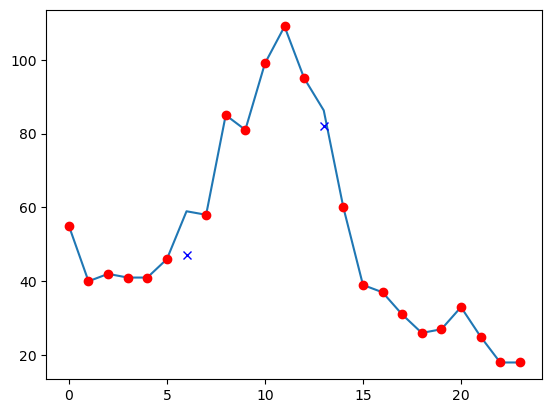

In [ ]:
plt.plot(imputation_brits['imputation'][day][:, station])
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
from pypots.imputation import GPVAE

gp_vae = GPVAE(n_steps=n_steps, n_features=n_features, latent_size=256, epochs=200, encoder_sizes=(256, 256), decoder_sizes=(256, 256), saving_path='gp_vae')
gp_vae.fit(dataset)

2024-05-06 15:04:17 [INFO]: No given device, using default device: cuda
2024-05-06 15:04:17 [INFO]: Model files will be saved to gp_vae/20240506_T150417
2024-05-06 15:04:17 [INFO]: Tensorboard file will be saved to gp_vae/20240506_T150417/tensorboard
2024-05-06 15:04:18 [INFO]: GPVAE initialized with the given hyperparameters, the number of trainable parameters: 407,308
2024-05-06 15:05:01 [INFO]: Epoch 001 - training loss: 3770157.0703
2024-05-06 15:05:03 [INFO]: Epoch 002 - training loss: 485182.6406
2024-05-06 15:05:05 [INFO]: Epoch 003 - training loss: 304037.2240
2024-05-06 15:05:07 [INFO]: Epoch 004 - training loss: 234538.1393
2024-05-06 15:05:10 [INFO]: Epoch 005 - training loss: 210660.2148
2024-05-06 15:05:12 [INFO]: Epoch 006 - training loss: 199813.2943
2024-05-06 15:05:14 [INFO]: Epoch 007 - training loss: 187545.3685
2024-05-06 15:05:16 [INFO]: Epoch 008 - training loss: 181070.1602
2024-05-06 15:05:19 [INFO]: Epoch 009 - training loss: 176433.1823
2024-05-06 15:05:21 [IN

In [ ]:
imputation_gp_vae = gp_vae.predict(dataset, n_sampling_times=n_preds)  # impute the originally-missing values and artificially-missing values
mae_gp_vae = calc_mae(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
rmse_gp_vae = calc_rmse(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
mape_gp_vae = calc_mre(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
crps_gp_vae = calc_quantile_crps(imputation_gp_vae['imputation'], np.nan_to_num(X_ori), indicating_mask)
nlpd_gp_vae = calc_nlpd(np.mean(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_gp_vae['imputation'], axis=1))
picp_gp_vae = calc_picp(np.mean(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_gp_vae['imputation'], axis=1))

/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
print(mae_gp_vae, rmse_gp_vae, mape_gp_vae, crps_gp_vae, nlpd_gp_vae, picp_gp_vae)

17.2050979862118 27.829299681313326 0.20232512561053248 0.20232510566711426 133193329075667.95 0.0


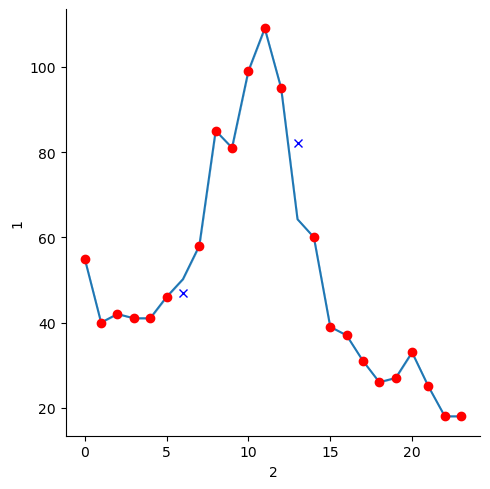

In [ ]:
d = pd.DataFrame(columns=['1', '2'])
for i in range(n_preds):
    for j in range(n_steps):
        d = pd.concat([d, pd.DataFrame([{'1': imputation_gp_vae['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
sns.relplot(data=d, y = '1', x='2', kind='line')
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
np.save('imputation_csdi_air_3', imputation_csdi['imputation'])
np.save('imputation_saits_air_3', imputation_saits['imputation'])
np.save('imputation_brits_air_3', imputation_brits['imputation'])
np.save('imputation_gp_vae_air_3', imputation_gp_vae['imputation'])

In [ ]:
pd.DataFrame([[mae_csdi, rmse_csdi, mape_csdi, crps_csdi, nlpd_csdi, picp_csdi],
             [mae_saits, rmse_saits, mape_saits, crps_saits, -1, -1],
             [mae_brits, rmse_brits, mape_brits, crps_brits, -1, -1],
             [mae_gp_vae, rmse_gp_vae, mape_gp_vae, crps_gp_vae, nlpd_gp_vae, picp_gp_vae]], index=['CSDI', 'SAITS', 'BRITS', 'GP VAE'], columns=['MAE', 'RMSE', 'MAPE', 'CRPS', 'NLPD', 'PICP'])

,MAE,RMSE,MAPE,CRPS,NLPD,PICP
CSDI,17.210355,32.907196,0.202387,0.369751,1.282951e+01,0.914149
SAITS,19.263989,31.314704,0.226537,0.226537,-1.000000e+00,-1.000000
BRITS,12.690332,22.256011,0.149233,0.149233,-1.000000e+00,-1.000000
GP VAE,17.205098,27.829300,0.202325,0.202325,1.331933e+14,0.000000


In [ ]:
days = np.random.randint(36, size=10)
stations = np.random.randint(12, size=10)

<Figure size 2000x2000 with 0 Axes>

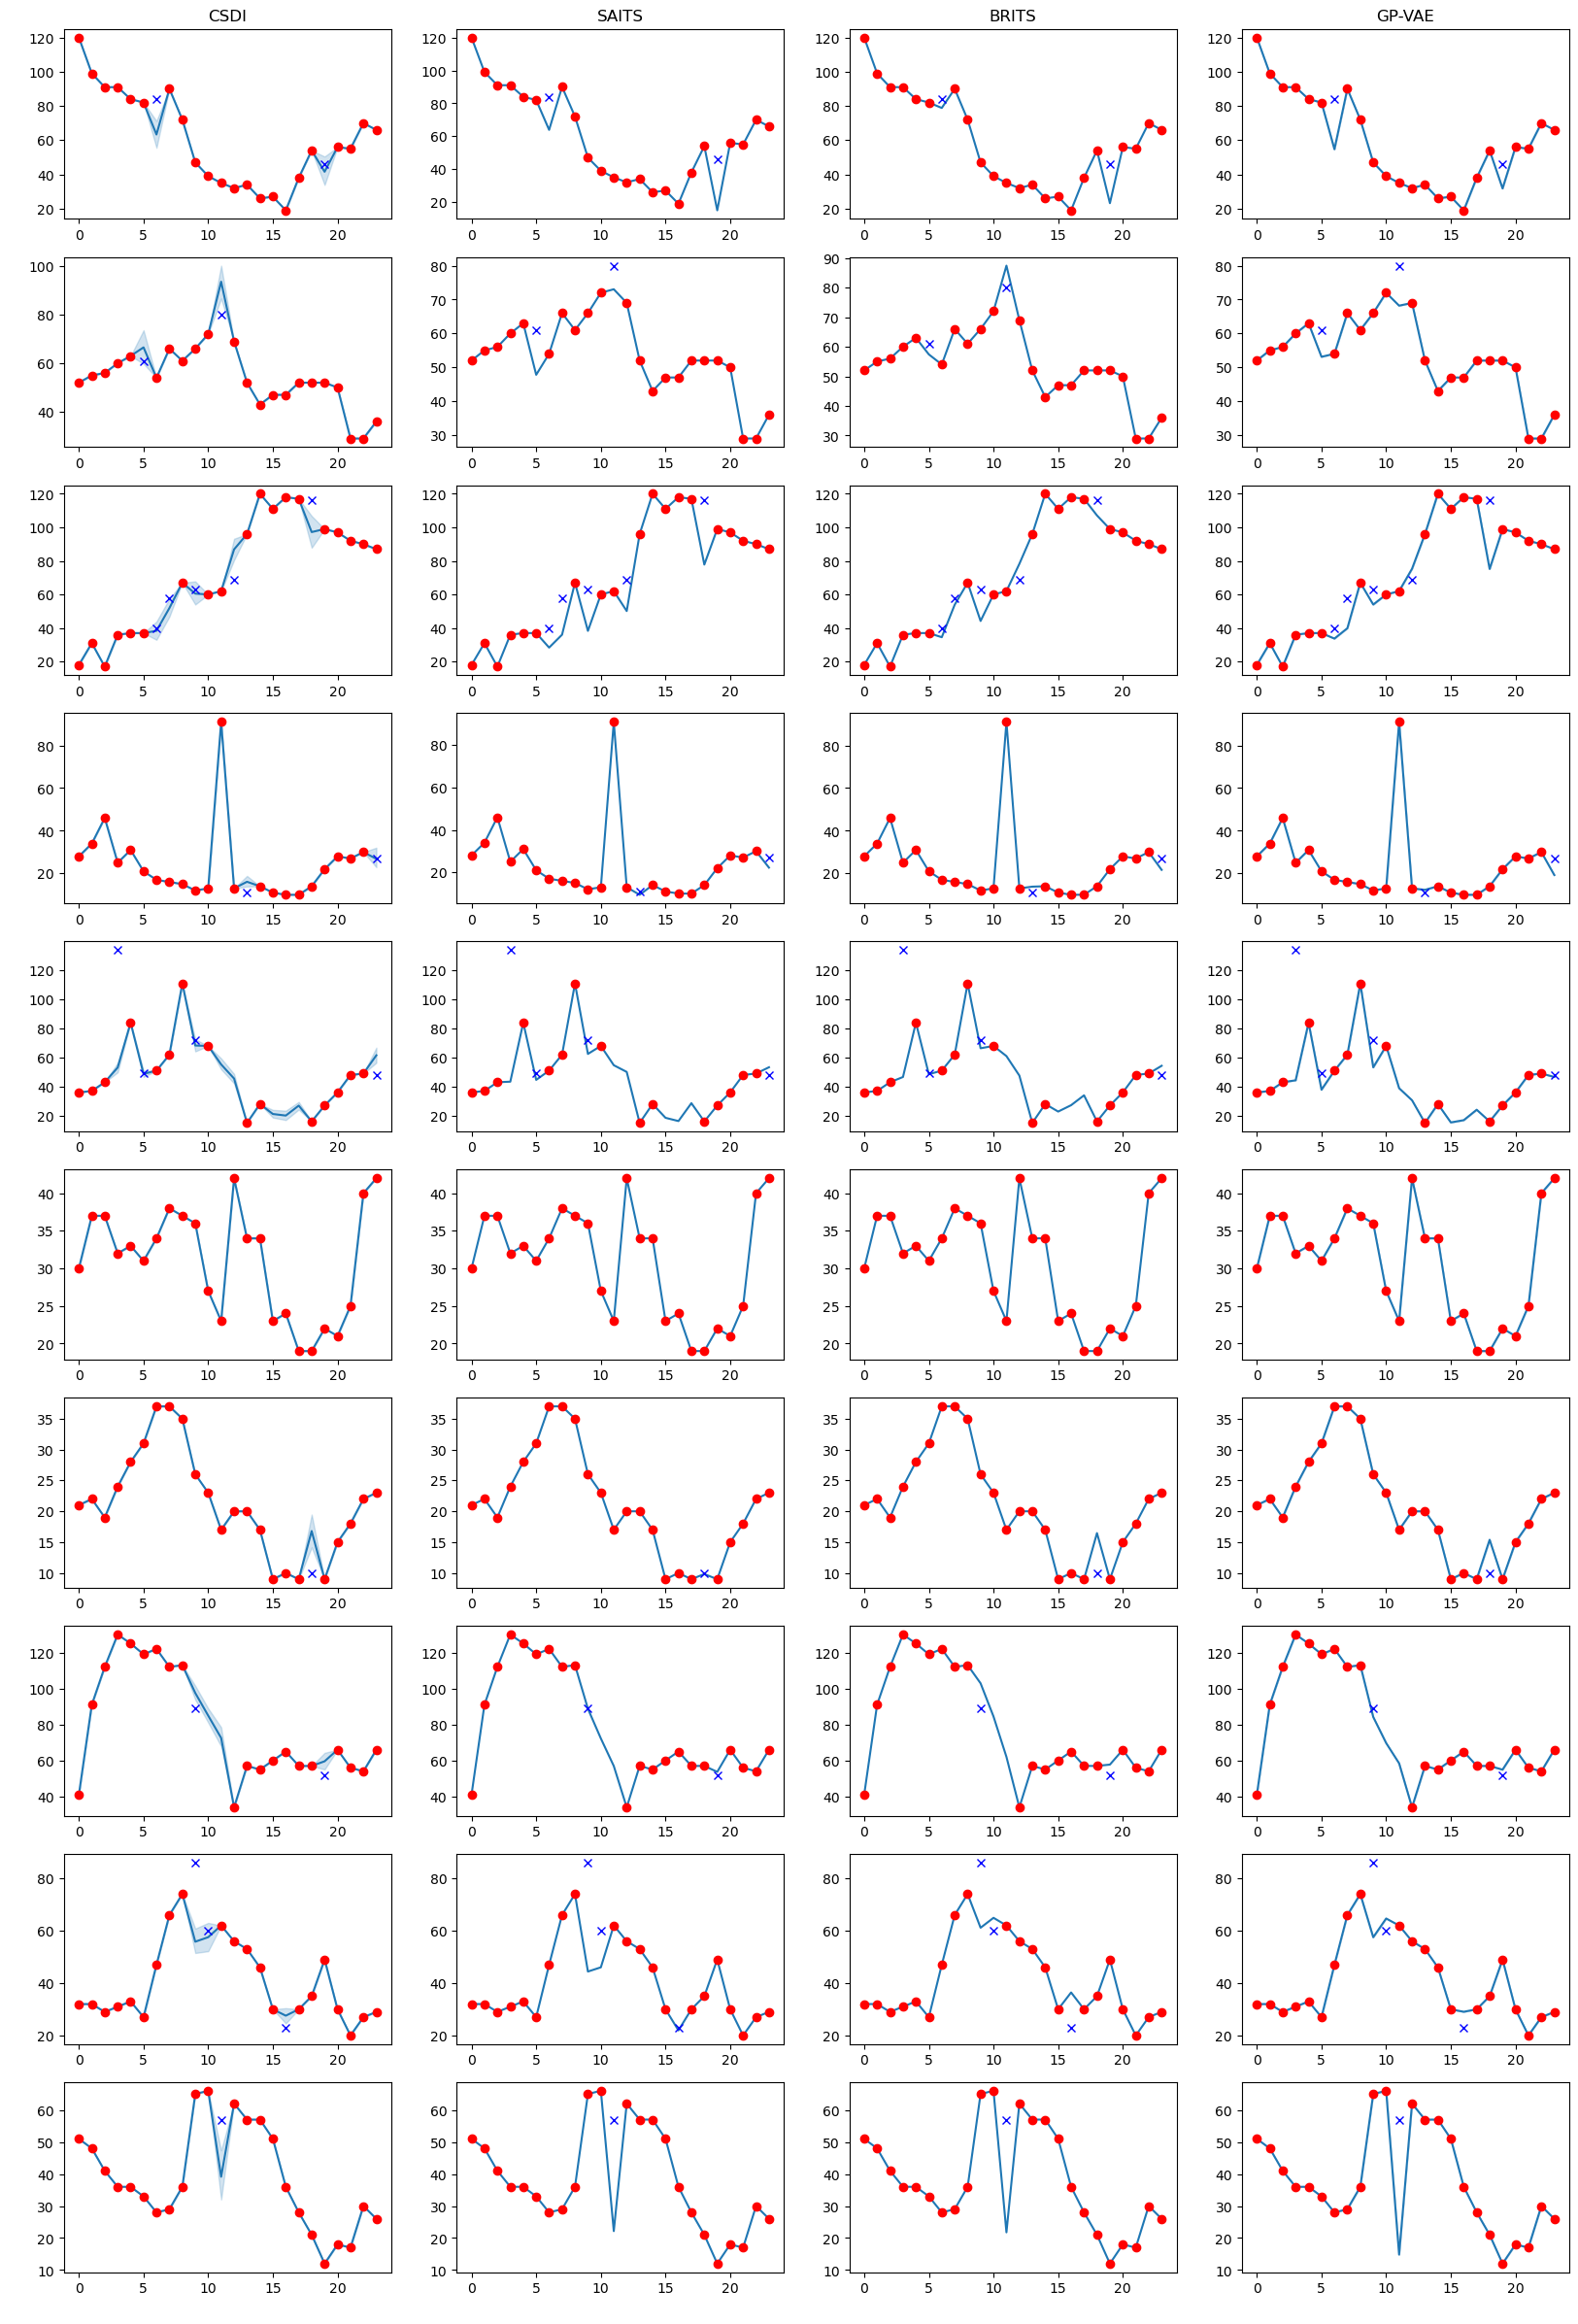

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))
fig, ax = plt.subplots(10, 4)
fig.set_figheight(30)
fig.set_figwidth(20)

for ids, day_station in enumerate(zip(days, stations)):
    day = day_station[0]
    station = day_station[1]
    n_preds = 30

    ax[0][0].set_title('CSDI')
    ax[0][1].set_title('SAITS')
    ax[0][2].set_title('BRITS')
    ax[0][3].set_title('GP-VAE')
    ax[ids][0].set_xlabel(' ')
    ax[ids][1].set_xlabel(' ')
    ax[ids][2].set_xlabel(' ')
    ax[ids][3].set_xlabel(' ')
    ax[ids][0].set_ylabel(' ')
    ax[ids][1].set_ylabel(' ')
    ax[ids][2].set_ylabel(' ')
    ax[ids][3].set_ylabel(' ')

    d = pd.DataFrame(columns=['1', '2'])
    for i in range(n_preds):
        for j in range(n_steps):
            d = pd.concat([d, pd.DataFrame([{'1': imputation_csdi['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
    sns.lineplot(data=d, y = '1', x='2', ax=ax[ids, 0])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 0].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    ax[ids, 1].plot(imputation_saits['imputation'][day][:, station])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 1].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    ax[ids, 2].plot(imputation_brits['imputation'][day][:, station])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 2].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    d = pd.DataFrame(columns=['1', '2'])
    for i in range(n_preds):
        for j in range(n_steps):
            d = pd.concat([d, pd.DataFrame([{'1': imputation_gp_vae['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
    sns.lineplot(data=d, y = '1', x='2', ax=ax[ids, 3])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 3].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')